In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [3]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [4]:
y.shape, tx.shape

((10000,), (10000, 2))

# 1 Computing the Cost Function

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [5]:
def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y.reshape((-1,1)) - tx@w
    return np.squeeze(e.T @ e) / (2*len(y))

# 2 Grid Search

Fill in the function `grid_search()` below:

In [6]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for i, w0_val in enumerate(w0):
        for j, w1_val in enumerate(w1):
            losses[i][j] = compute_loss(y, tx, np.array([[w0_val], [w1_val]]))
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=18.793541019523236, w0*=71.42857142857142, w1*=15.306122448979579, execution time=0.229 seconds


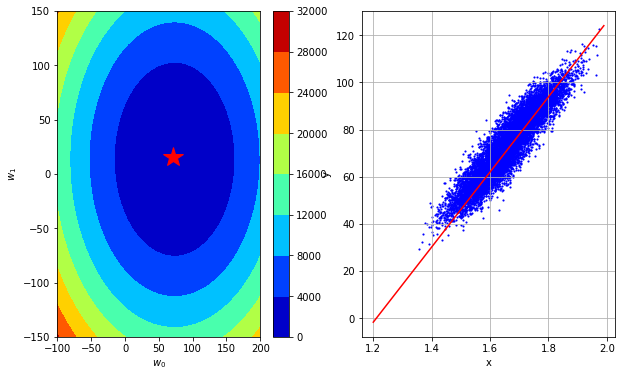

In [7]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [8]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    return - tx.T @ (y.reshape((-1,1)) - tx@w) / len(y)

In [9]:
compute_gradient(y, tx, np.array([[1], [2]]))
# compute_gradient(np.array([2.0]), np.array([[1.0,2.0]]), np.array([[50.0], [10.0]]))

array([[-72.293922  ],
       [-11.47971243]])

Please fill in the functions `gradient_descent` below:

In [10]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss(y, tx, w.reshape((-1,1)))
        grad = compute_gradient(y, tx, w.reshape((-1,1)))
        w = w - gamma * np.squeeze(grad)
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [16]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([-100.0, 100.0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=18773.657669470802, w0=21.305745401473672, w1=39.435798704492186
Gradient Descent(1/49): loss=1703.6303482130006, w0=57.69746902191576, w1=21.266538315839945
Gradient Descent(2/49): loss=167.3278892998041, w0=68.61498610804836, w1=15.815760199244306
Gradient Descent(3/49): loss=29.060667997617113, w0=71.89024123388815, w1=14.180526764265622
Gradient Descent(4/49): loss=16.616618080420285, w0=72.87281777164007, w1=13.68995673377202
Gradient Descent(5/49): loss=15.49665358787258, w0=73.16759073296565, w1=13.54278572462394
Gradient Descent(6/49): loss=15.39585678354329, w0=73.25602262136333, w1=13.498634421879515
Gradient Descent(7/49): loss=15.38678507115365, w0=73.28255218788263, w1=13.485389031056188
Gradient Descent(8/49): loss=15.38596861703858, w0=73.29051105783842, w1=13.48141541380919
Gradient Descent(9/49): loss=15.38589513616823, w0=73.29289871882516, w1=13.480223328635091
Gradient Descent(10/49): loss=15.38588852288989, w0=73.29361501712118, w1=13.4

In [17]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4 Stochastic gradient descent

In [13]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    return compute_gradient(y, tx, w)


def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            loss = compute_loss(y, tx, w.reshape((-1,1)))
            grad = compute_stoch_gradient(y, tx, w.reshape((-1,1)))
            w = w - gamma * np.squeeze(grad)
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [14]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2792.236712759168, w0=51.30574540147361, w1=9.435798704492269
Gradient Descent(1/49): loss=265.3024621089606, w0=66.69746902191571, w1=12.266538315839997
Gradient Descent(2/49): loss=37.87837955044127, w0=71.31498610804834, w1=13.115760199244328
Gradient Descent(3/49): loss=17.410212120174478, w0=72.70024123388814, w1=13.37052676426563
Gradient Descent(4/49): loss=15.568077051450457, w0=73.11581777164007, w1=13.446956733772023
Gradient Descent(5/49): loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
Gradient Descent(6/49): loss=15.38736360120863, w0=73.27789262136334, w1=13.476764421879516
Gradient Descent(7/49): loss=15.386020684743528, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=15.38589982226167, w0=73.29247935783842, w1=13.47944711380919
Gradient Descent(9/49): loss=15.385888944638301, w0=73.29348920882516, w1=13.47963283863509
Gradient Descent(10/49): loss=15.3858879656522, w0=73.29379216412119, w1=13.479

In [15]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5 Effect of Outliers

### Exercise 5


# 6 Subgradient Descent

### Exercise 6

Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)